# Autoencoder

Autoencoder trained on CIFAR10.

- Imports.
- Train, val, and test datasets and dataloaders. Input images are normalized to have values between -1 and 1.
- `Encoder` class. `(batch_size, 3, 32, 32)` input tensors put through several 2d convolutions (followed by GELU activation), flattened (using `einops Rearrange`), and put through a linear layer with `latent_dim` out size.
- `Decoder` class. Reverse of the encoder class. 
- `Autoencoder` Lightning module using MSE loss summed over all pixels and averaged over the batch.
- Function to train and evaluate autoencoder.
- Train autoencoder (very briefly), with latent dims `64` and `128`.
- Visualize some reconstructed images.
- Attempt to reconstruct noise.
- Attempt to reconstruct solid blocks of colour.
- Generate new images by passing random latent vectors into the decoder.

### Imports

In [44]:
import os

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

from einops.layers.torch import Rearrange

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

pl.seed_everything(42)

DATASET_PATH = 'data'
CHECKPOINT_PATH = 'checkpoints'

Seed set to 42


### Datasets and dataloaders

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, ), (0.5,))
])
train_dataset = CIFAR10(root=DATASET_PATH, train=True,
                        download=True, transform=transform) 
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

test_set = CIFAR10(root=DATASET_PATH, train=False,
                     download=True, transform=transform) 

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

Files already downloaded and verified


Seed set to 42


Files already downloaded and verified


### Encoder

In [32]:
class Encoder(nn.Module):

    def __init__(self, base_channel_size, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, base_channel_size, 
                kernel_size=3, padding=1, stride=2), # 32x32 -> 16x16
            nn.GELU(),
            nn.Conv2d(base_channel_size, base_channel_size, 
                kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channel_size, 2*base_channel_size,
                kernel_size=3, padding=1, stride=2), # 16x16 -> 8x8
            nn.GELU(),  
            nn.Conv2d(2*base_channel_size, 2*base_channel_size,
                kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*base_channel_size, 2*base_channel_size,
                kernel_size=3, padding=1, stride=2), # 8x8 -> 4x4
            nn.GELU(),
            Rearrange('b c h w -> b (c h w)'),  
            nn.Linear(2*base_channel_size*4*4, latent_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)

### Decoder

In [33]:
class Decoder(nn.Module):

    def __init__(self, base_channel_size, latent_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2*base_channel_size*4*4),
            Rearrange('b (c h w) -> b c h w', c=2*base_channel_size, h=4, w=4),
            nn.ConvTranspose2d(2*base_channel_size, 2*base_channel_size,    
                kernel_size=3, padding=1, stride=2, output_padding=1), # 4x4 -> 8x8
            nn.GELU(),
            nn.Conv2d(2*base_channel_size, 2*base_channel_size,
                kernel_size=3, padding=1),  
            nn.GELU(),
            nn.ConvTranspose2d(2*base_channel_size, base_channel_size,
                kernel_size=3, padding=1, stride=2, output_padding=1), # 8x8 -> 16x16   
            nn.GELU(),
            nn.Conv2d(base_channel_size, base_channel_size,
                kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(base_channel_size, 3,
                kernel_size=3, padding=1, stride=2, output_padding=1), # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

### Lightning module

In [34]:
class Autoencoder(pl.LightningModule):

    def __init__(self, base_channel_size, latent_dim):
        super().__init__()
        self.encoder = Encoder(base_channel_size, latent_dim)
        self.decoder = Decoder(base_channel_size, latent_dim)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)   

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def _get_loss(self, batch):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x, x_hat, reduction='none')
        loss = loss.sum(dim=(1, 2, 3)).mean()
        return loss

    def configure_optimizers(self):
        return self.optimizer
    
    def training_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log('test_loss', loss)
      

### Function to train and evaluate autoencoder

In [35]:
def train_autoencoder(latent_dim):

    trainer = Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'Autoencoder_{}'.format(latent_dim)),
        accelerator='cpu',
        max_epochs=10,
        callbacks=[ModelCheckpoint(save_weights_only=True)],
        enable_progress_bar=True,
        limit_train_batches=0.2,
        limit_val_batches=0.2,
        limit_test_batches=0.3
    )
    trainer.logger._default_hp_metric = None

    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    trainer.fit(model, train_loader, val_loader)

    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

### Train and evaluate autoencoder

In [40]:
model_dict = {}

for latent_dim in [64, 128]:
    model_ld, result_ld = train_autoencoder(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, 
                                "result":result_ld}

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 168 K  | train
1 | decoder | Decoder | 168 K  | train
--------------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.348     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


c:\Users\skjda\anaconda3\envs\uva_dl1\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 35/35 [00:11<00:00,  3.16it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  6.60it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 233 K  | train
1 | decoder | Decoder | 234 K  | train
--------------------------------------------
468 K     Trainable params
0         Non-trainable params
468 K     Total params
1.873     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 35/35 [00:11<00:00,  3.13it/s, v_num=0]          

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]


### Visualize reconstructions

In [47]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs)

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {latent_dim} latent dimensions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

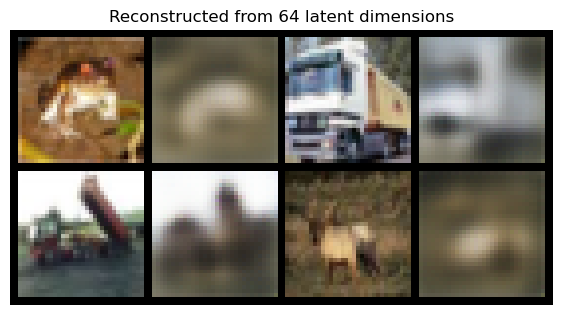

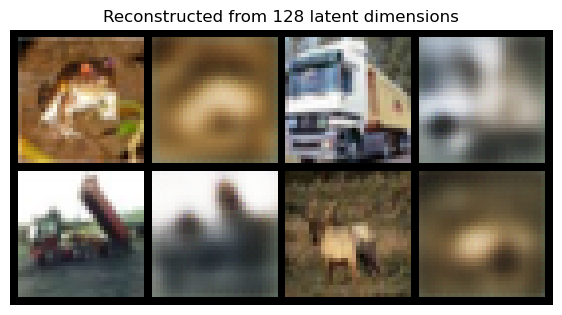

In [48]:
input_imgs = get_train_images(4)

for latent_dim in [64, 128]:
    model = model_dict[latent_dim]["model"]
    visualize_reconstructions(model, input_imgs)

### Attempt to reconstruct noise

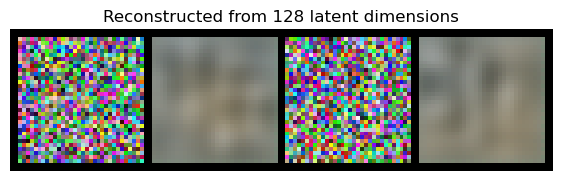

In [49]:
rand_imgs = torch.rand(2, 3, 32, 32) * 2 - 1
visualize_reconstructions(model_dict[128]["model"], rand_imgs)

### Attempt to reconstruct solid blocks of colour

c:\Users\skjda\anaconda3\envs\uva_dl1\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


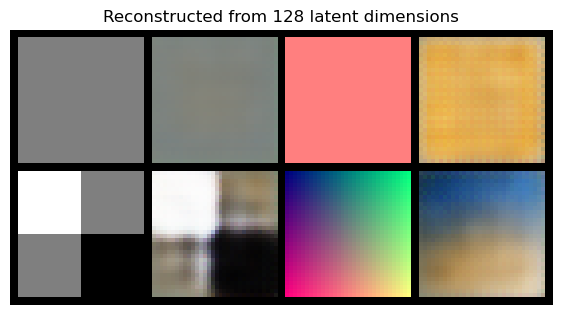

In [50]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color channel
plain_imgs[1,0] = 1
# Checkboard pattern
plain_imgs[2,:,:16,:16] = 1
plain_imgs[2,:,16:,16:] = -1
# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1,1,32), torch.linspace(-1,1,32))
plain_imgs[3,0,:,:] = xx
plain_imgs[3,1,:,:] = yy

visualize_reconstructions(model_dict[128]["model"], plain_imgs)

### Generate new images

Pass random vectors into the decoder.

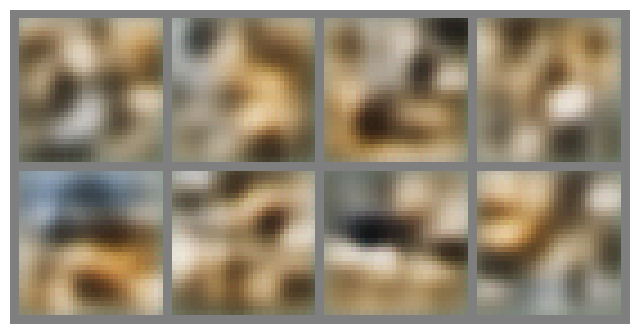

In [51]:
model = model_dict[128]["model"]
latent_vectors = torch.randn(8, 128)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()